In [145]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df = pd.read_csv("./data/Elspotprices.csv", sep=";")
df_load = pd.read_csv("./data/total_load.csv", sep=",")
df_gen = pd.read_csv("./data/generation_production.csv", sep=",")
df.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2024-04-13 21:00,2024-04-13 23:00,DK1,"52,590000","7,050000"
1,2024-04-13 20:00,2024-04-13 22:00,DK1,"153,679993","20,600000"
2,2024-04-13 19:00,2024-04-13 21:00,DK1,"258,500000","34,650002"
3,2024-04-13 18:00,2024-04-13 20:00,DK1,"298,630005","40,029999"
4,2024-04-13 17:00,2024-04-13 19:00,DK1,"373,760010","50,099998"


In [146]:
df_load.head()

,Time (CET/CEST),Day-ahead Total Load Forecast [MW] - BZN|DK1,Actual Total Load [MW] - BZN|DK1
0,01.01.2023 00:00 - 01.01.2023 01:00,2135.0,2158.0
1,01.01.2023 01:00 - 01.01.2023 02:00,2084.0,2123.0
2,01.01.2023 02:00 - 01.01.2023 03:00,2059.0,2128.0
3,01.01.2023 03:00 - 01.01.2023 04:00,2001.0,2026.0
4,01.01.2023 04:00 - 01.01.2023 05:00,1969.0,1986.0


In [147]:
TRAIN_DAYS= 300 

df = df[['HourDK', 'SpotPriceEUR' ]]
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df[(df['HourDK'] >= '2023-01-01') & (df['HourDK'] <= '2023-12-31')]
df = df.iloc[::-1]
df['item_id'] = 'electricity_price'
df['SpotPriceEUR'] = df['SpotPriceEUR'].str.replace(',', '.').astype(float)
df_test = df.copy()
df = df.iloc[:TRAIN_DAYS*24 - 1]
df_test = df_test.iloc[((TRAIN_DAYS-5)*24) -1:(TRAIN_DAYS+1)*24 -1]
df.head()


,HourDK,SpotPriceEUR,item_id
11254,2023-01-01 00:00:00,2.01,electricity_price
11253,2023-01-01 01:00:00,1.38,electricity_price
11252,2023-01-01 02:00:00,0.09,electricity_price
11251,2023-01-01 03:00:00,0.08,electricity_price
11250,2023-01-01 04:00:00,0.05,electricity_price


In [148]:

# Process the load data
df_load['Time (CET/CEST)'] = df_load['Time (CET/CEST)'].str.split(' - ').str[0]
df_load['Time (CET/CEST)'] = pd.to_datetime(df_load['Time (CET/CEST)'], format='%d.%m.%Y %H:%M')
df_load = df_load[['Time (CET/CEST)', 'Actual Total Load [MW] - BZN|DK1']]
df_load = df_load.rename(columns={'Time (CET/CEST)': 'timestamp', 'Actual Total Load [MW] - BZN|DK1': 'load'})

# Add item_id column
df_load['item_id'] = 'electricity_load'

# Create train and test sets
df_load_test = df_load.copy()
df_load = df_load.iloc[:TRAIN_DAYS*24]
df_load_test = df_load_test.iloc[((TRAIN_DAYS-5)*24):(TRAIN_DAYS+1)*24]

# Print first and last dates for df and df_load
print("DataFrame df date range:")
print(f"First date: {df['HourDK'].min()}")
print(f"Last date: {df['HourDK'].max()}")
print("\nDataFrame df_load date range:")
print(f"First date: {df_load['timestamp'].min()}")
print(f"Last date: {df_load['timestamp'].max()}")

# Print first and last dates for df_test and df_load_test
print("\nDataFrame df_test date range:")
print(f"First date: {df_test['HourDK'].min()}")
print(f"Last date: {df_test['HourDK'].max()}")
print("\nDataFrame df_load_test date range:")
print(f"First date: {df_load_test['timestamp'].min()}")
print(f"Last date: {df_load_test['timestamp'].max()}")


DataFrame df date range:
First date: 2023-01-01 00:00:00
Last date: 2023-10-27 23:00:00

DataFrame df_load date range:
First date: 2023-01-01 00:00:00
Last date: 2023-10-27 23:00:00

DataFrame df_test date range:
First date: 2023-10-23 00:00:00
Last date: 2023-10-28 23:00:00

DataFrame df_load_test date range:
First date: 2023-10-23 00:00:00
Last date: 2023-10-28 23:00:00


In [149]:
# Check for missing timestamps in df and df_load
print(f"df shape: {df.shape}")
print(f"df_load shape: {df_load.shape}")

# Ensure timestamps are aligned between df and df_load
# Convert timestamp column in df_load to match HourDK format in df
df_load['timestamp'] = pd.to_datetime(df_load['timestamp'])

# Check if there are any missing timestamps in df
df_hourly_range = pd.date_range(start=df['HourDK'].min(), end=df['HourDK'].max(), freq='H')
missing_hours_df = set(df_hourly_range) - set(df['HourDK'])
print(f"Missing hours in df: {len(missing_hours_df)}")
if missing_hours_df:
    print(f"Example missing hours: {list(missing_hours_df)[:5]}")

# Check if there are any missing timestamps in df_load
df_load_hourly_range = pd.date_range(start=df_load['timestamp'].min(), end=df_load['timestamp'].max(), freq='H')
missing_hours_df_load = set(df_load_hourly_range) - set(df_load['timestamp'])
print(f"Missing hours in df_load: {len(missing_hours_df_load)}")
if missing_hours_df_load:
    print(f"Example missing hours: {list(missing_hours_df_load)[:5]}")

# Fix the issue by reindexing df to ensure it has all hourly timestamps
if len(missing_hours_df) > 0:
    # Create a complete hourly index
    full_range = pd.date_range(start=df['HourDK'].min(), end=df['HourDK'].max(), freq='H')
    
    # Create a template dataframe with all hours
    template_df = pd.DataFrame({'HourDK': full_range})
    
    # Merge with original df to fill in missing hours
    df = pd.merge(template_df, df, on='HourDK', how='left')
    
    # Fill missing values (if any)
    df['item_id'] = df['item_id'].fillna('electricity_price')
    # Forward fill or interpolate price values as appropriate
    df['SpotPriceEUR'] = df['SpotPriceEUR'].interpolate(method='linear')
    
    print(f"Fixed df shape: {df.shape}")
# Ensure both dataframes have the same number of rows
print(f"Final df shape: {df.shape}")
print(f"Final df_load shape: {df_load.shape}")


df shape: (7199, 3)
df_load shape: (7200, 3)
Missing hours in df: 1
Example missing hours: [Timestamp('2023-03-26 02:00:00')]
Missing hours in df_load: 0
Fixed df shape: (7200, 3)
Final df shape: (7200, 3)
Final df_load shape: (7200, 3)


C:\Users\marchesi\AppData\Local\Temp\ipykernel_3908\1634638012.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly_range = pd.date_range(start=df['HourDK'].min(), end=df['HourDK'].max(), freq='H')
C:\Users\marchesi\AppData\Local\Temp\ipykernel_3908\1634638012.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_load_hourly_range = pd.date_range(start=df_load['timestamp'].min(), end=df_load['timestamp'].max(), freq='H')
C:\Users\marchesi\AppData\Local\Temp\ipykernel_3908\1634638012.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df['HourDK'].min(), end=df['HourDK'].max(), freq='H')


In [150]:
df = df.assign(load=df_load['load'].values)
df_test = df_test.assign(load=df_load_test['load'].values)
df.tail()

,HourDK,SpotPriceEUR,item_id,load
7195,2023-10-27 19:00:00,140.539993,electricity_price,2624.0
7196,2023-10-27 20:00:00,120.889999,electricity_price,2511.0
7197,2023-10-27 21:00:00,100.050003,electricity_price,2409.0
7198,2023-10-27 22:00:00,96.839996,electricity_price,2285.0
7199,2023-10-27 23:00:00,93.699997,electricity_price,2182.0


In [151]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="HourDK",
)
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="item_id",
    timestamp_column="HourDK",
)

test_data.head()

SpotPriceEUR    load
item_id           timestamp                                
electricity_price 2023-10-23 00:00:00     99.459999  2076.0
                  2023-10-23 01:00:00     67.169998  2043.0
                  2023-10-23 02:00:00     80.290001  2024.0
                  2023-10-23 03:00:00     67.139999  1995.0
                  2023-10-23 04:00:00     75.449997  2059.0

In [152]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    path="autogluon-m4-hourly",
    target="SpotPriceEUR",
    eval_metric="MASE",
    freq="h",
)

predictor.fit(
    train_data,
    presets="high_quality",
    time_limit=600,
)

c:\energy_price_forecasting\Lib\site-packages\autogluon\timeseries\predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\energy_price_forecasting\autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       2.54 GB / 15.73 GB (16.2%)
Disk Space Avail:   265.81 GB / 456.62 GB (58.2%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3

In [153]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2  \
item_id           timestamp                                              
electricity_price 2023-10-28 00:00:00  91.343152  78.883435  83.148034   
                  2023-10-28 01:00:00  88.642153  71.599545  77.832812   
                  2023-10-28 02:00:00  84.570135  63.591870  71.712157   
                  2023-10-28 03:00:00  84.170543  59.867185  69.523475   
                  2023-10-28 04:00:00  86.205819  58.506575  69.599216   

                                             0.3        0.4        0.5  \
item_id           timestamp                                              
electricity_price 2023-10-28 00:00:00  86.142107  88.133605  91.343152   
                  2023-10-28 01:00:00  81.659999  84.609710  88.642153   
                  2023-10-28 02:00:00  76.330905  79.891865  84.570135   
                  2023-10-28 03:00:00  74.934441  78.968663  84.170543   
                  2023-10-28 04:00:00  75.855958  80.482982  86.205819   

                                             0.6        0.7         0.8  \
item_id           timestamp                                               
electricity_price 2023-10-28 00:00:00  93.220353  96.038994   97.847877   
                  2023-10-28 01:00:00  91.249695  94.668988   97.995712   
                  2023-10-28 02:00:00  87.845182  92.074324   96.744366   
                  2023-10-28 03:00:00  88.087825  93.112089   98.907058   
                  2023-10-28 04:00:00  90.892942  96.771498  103.704755   

                                              0.9  
item_id           timestamp                        
electricity_price 2023-10-28 00:00:00  102.803806  
                  2023-10-28 01:00:00  104.422364  
                  2023-10-28 02:00:00  104.499171  
                  2023-10-28 03:00:00  107.863766  
                  2023-10-28 04:00:00  113.951135

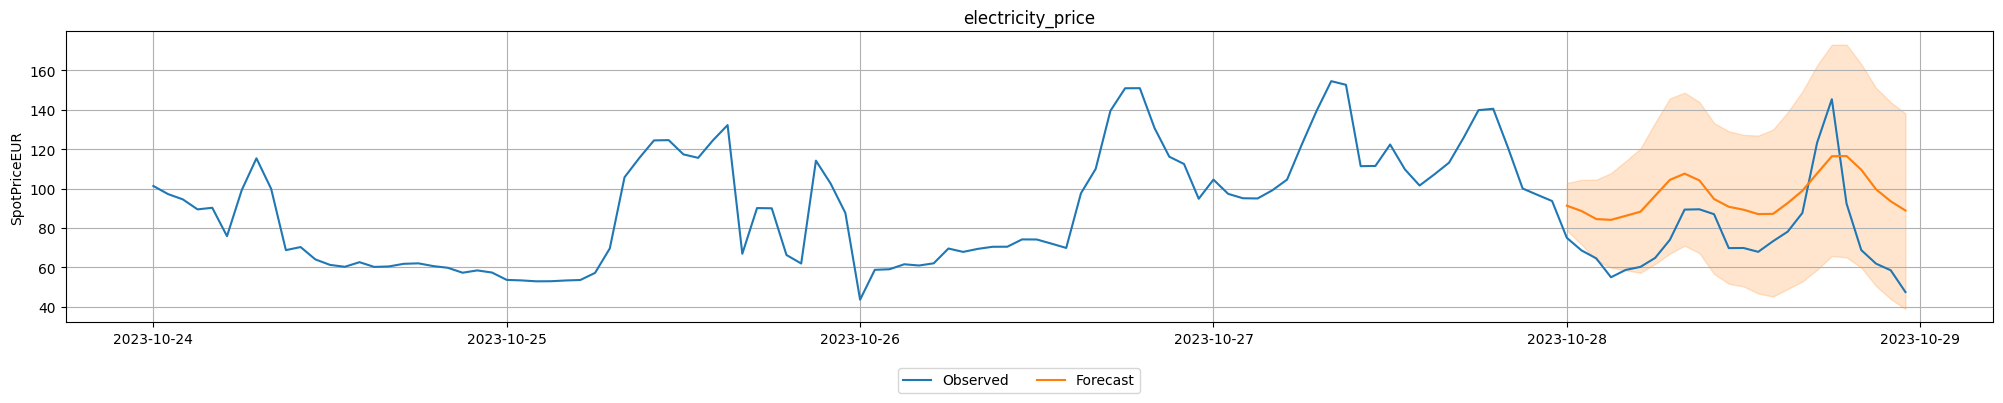

In [155]:
import matplotlib.pyplot as plt
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)

In [156]:
# The test score is computed using the last
# prediction_length=24 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TemporalFusionTransformer,-0.472815,-0.323633,0.073076,0.034116,96.740351,8
1,DynamicOptimizedTheta,-0.546329,-1.021504,28.369658,29.933202,0.009542,5
2,RecursiveTabular,-0.572381,-0.469239,0.643533,1.255402,2.404091,2
3,AutoETS,-0.624635,-0.653132,3.881413,4.197563,0.015333,6
4,WeightedEnsemble,-0.673156,-0.290866,2.702447,4.459867,0.428169,12
5,NPTS,-0.701962,-1.118167,1.713238,3.111200,0.022810,4
6,DirectTabular,-0.712416,-1.590467,0.156826,0.267640,2.117277,3
7,ChronosZeroShot[bolt_base],-0.785675,-0.497454,1.953319,3.142492,20.066399,7
8,TiDE,-0.834831,-0.513772,0.075499,0.029919,124.879021,11
9,PatchTST,-0.878107,-0.323789,0.030499,0.027858,52.504345,10


In [ ]:
predictions = predictor.predict(train_data, model='TemporalFusionTransformer')
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)